In [1]:
!pip install statsmodels

In [2]:
import pandas as pd
import numpy as np 

import statsmodels.formula.api as sm # module for stats models
from statsmodels.iolib.summary2 import summary_col # module for presenting stats models outputs nicely

In [3]:
def price2ret(prices,retType='simple'):
    if retType == 'simple':
        ret = (prices/prices.shift(1))-1
    else:
        ret = np.log(prices/prices.shift(1))
    return ret

In [4]:
def assetPriceReg(df_stk):
    import pandas_datareader.data as web  # module for reading datasets directly from the web
    
    # Reading in factor data
    df_factors = web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench')[0]
    df_factors.rename(columns={'Mkt-RF': 'MKT'}, inplace=True)
    df_factors['MKT'] = df_factors['MKT']/100
    df_factors['SMB'] = df_factors['SMB']/100
    df_factors['HML'] = df_factors['HML']/100
    df_factors['RMW'] = df_factors['RMW']/100
    df_factors['CMA'] = df_factors['CMA']/100
    
    df_stock_factor = pd.merge(df_stk,df_factors,left_index=True,right_index=True) # Merging the stock and factor returns dataframes together
    df_stock_factor['XsRet'] = df_stock_factor['Returns'] - df_stock_factor['RF'] # Calculating excess returns

    # Running CAPM, FF3, and FF5 models.
    CAPM = sm.ols(formula = 'XsRet ~ MKT', data=df_stock_factor).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    FF3 = sm.ols( formula = 'XsRet ~ MKT + SMB + HML', data=df_stock_factor).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    FF5 = sm.ols( formula = 'XsRet ~ MKT + SMB + HML + RMW + CMA', data=df_stock_factor).fit(cov_type='HAC',cov_kwds={'maxlags':1})

    CAPMtstat = CAPM.tvalues
    FF3tstat = FF3.tvalues
    FF5tstat = FF5.tvalues

    CAPMcoeff = CAPM.params
    FF3coeff = FF3.params
    FF5coeff = FF5.params

    # DataFrame with coefficients and t-stats
    results_df = pd.DataFrame({'CAPMcoeff':CAPMcoeff,'CAPMtstat':CAPMtstat,
                               'FF3coeff':FF3coeff, 'FF3tstat':FF3tstat,
                               'FF5coeff':FF5coeff, 'FF5tstat':FF5tstat},
    index = ['Intercept', 'MKT', 'SMB', 'HML', 'RMW', 'CMA'])


    dfoutput = summary_col([CAPM,FF3, FF5],stars=True,float_format='%0.4f',
                  model_names=['CAPM','FF3','FF5'],
                  info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
                             'Adjusted R2':lambda x: "{:.4f}".format(x.rsquared_adj)}, 
                             regressor_order = ['Intercept', 'MKT', 'SMB', 'HML', 'RMW', 'CMA'])

    print(dfoutput)
    
    return results_df

In [5]:

df_stk = pd.read_csv("ibm.csv",index_col='Date',parse_dates=True)
df_stk.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,132.970001,130.850006,131.179993,132.449997,6155300.0,95.994934
2010-01-05,131.850006,130.100006,131.679993,130.850006,6841400.0,94.835304
2010-01-06,131.490005,129.809998,130.679993,130.000000,5605300.0,94.219246
2010-01-07,130.250000,128.910004,129.869995,129.550003,5840600.0,93.893105
2010-01-08,130.919998,129.050003,129.070007,130.850006,4197200.0,94.835304


In [6]:
df_stk.drop(['Volume'],axis=1,inplace=True)
df_stk.plot()

In [7]:
df_stk['Returns'] = price2ret(df_stk[['Adj Close']])
df_stk = df_stk.dropna()
df_stk.head()

,High,Low,Open,Close,Adj Close,Returns
Date,,,,,,
2010-01-05,131.850006,130.100006,131.679993,130.850006,94.835304,-0.012080
2010-01-06,131.490005,129.809998,130.679993,130.000000,94.219246,-0.006496
2010-01-07,130.250000,128.910004,129.869995,129.550003,93.893105,-0.003462
2010-01-08,130.919998,129.050003,129.070007,130.850006,94.835304,0.010035
2010-01-11,131.059998,128.669998,131.059998,129.479996,93.842384,-0.010470


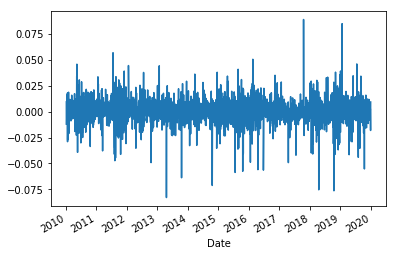

In [8]:
df_stk['Returns'].plot()

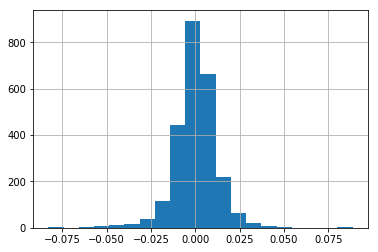

In [9]:
df_stk['Returns'].hist(bins=20)

In [10]:
df_regOutput = assetPriceReg(df_stk)

c:\users\smit2\appdata\local\programs\python\python37-32\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal



               CAPM       FF3        FF5    
--------------------------------------------
Intercept   -0.0044*** -0.0044*** -0.0045***
            (0.0003)   (0.0003)   (0.0003)  
MKT         0.9319***  0.9626***  1.0100*** 
            (0.0328)   (0.0322)   (0.0358)  
SMB                    -0.2049*** -0.1737** 
                       (0.0667)   (0.0700)  
HML                    0.2057***  0.1030    
                       (0.0665)   (0.0806)  
RMW                               0.3044*** 
                                  (0.1025)  
CMA                               0.2758**  
                                  (0.1349)  
R-squared   0.3636     0.3746     0.3822    
            0.3641     0.3761     0.3848    
N           1199       1199       1199      
Adjusted R2 0.3636     0.3746     0.3822    
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
